In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.externals.h5io import read_hdf5, write_hdf5
from library import viz

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter
import plotly.tools as tls
import matplotlib

Managing fonts can be a pain ... 
This one brought the solution.

http://stackoverflow.com/questions/21461155/change-matplotlibs-default-font

Short: copy the fonts from mac and register them.

In [3]:
matplotlib.font_manager.fontManager.findfont('Helvetica')

u'/usr/share/fonts/myfonts/Helvetica.ttf'

In [4]:
import plotly.graph_objs as pgo
init_notebook_mode()

In [5]:
mne.utils.set_log_level('warning')

In [6]:
df = pd.read_csv('unrelated_MEG_subjects.csv')
subjects_missing = pd.read_csv('missing_freesurfer_s900_unrelated.csv').SubjectId.tolist()
subjects = [str(sub) for sub in df.Subject.tolist() if sub not in subjects_missing]

In [7]:
with open('unrelated_subjects.txt', 'w') as fid:
    fid.write('\n'.join(subjects))

In [8]:
# %%bash
# rm download_output.txt
# for sub in $(cat unrelated_subjects.txt)
# do
#     echo "downloading epochs for ${sub}" 
#     python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
#     --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
# done &> download_output.txt

In [117]:
recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(3):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            epochs.events[:, 2].fill(run_index)
            epochs.event_id = {'run%d' % run_index: run_index}
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

In [119]:
epochs = get_epochs_for_subject(subjects[1])
X = np.log10(epochs.get_data())
freqs = np.linspace(0.001, 127, len(epochs.times))

In [11]:
from hcp.preprocessing import make_hcp_bti_layout
lout = make_hcp_bti_layout(info=epochs.info)

In [12]:
epochs.times[:] = freqs

In [13]:
import seaborn as sns
sns.set(style='ticks', palette='Set2')
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 


In [14]:
def plot_topomap(inst, points, unit, cmap='magma', time_format='%0.2fHZ', **kwargs):
    return inst.plot_topomap(
        points, scale=1, size=2, vmin=np.min, vmax=np.max, cmap=cmap,
        contours=0, scale_time=1, time_format=time_format, layout=lout, unit=unit, **kwargs);

In [44]:
for subject in subjects:
    %run hcp_compute_subject.py --storage_dir /mnt \
    --subject $subject \
    --hcp_no_meg --hcp_no_anat \
    --keep_files \
    --s3_overwrite_downloads \
    --downloaders '~/github/meg_study_dynamic_scales/scripts/library:downloaders.get_1of_sensor_outputs'\

Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 599671
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 665254
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 825048
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 877168
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "

In [25]:
arrythmic_fnames = glob.glob('/mnt/hcp-meg/??????/psds-loglinear-fit-0p1-1.h5')

In [120]:
fname = [ff for ff in  arrythmic_fnames if subjects[1] in ff][0]
arr = mne.externals.h5io.read_hdf5(fname)

In [49]:
np.mean(np.mean(arr['intercepts'],0), 0) * 10

-234.4875298506075

# Figure 1 materials

a) show for 1 subject alpha, 1/f and topos

b) show psds for all subjects

c) show grand averages

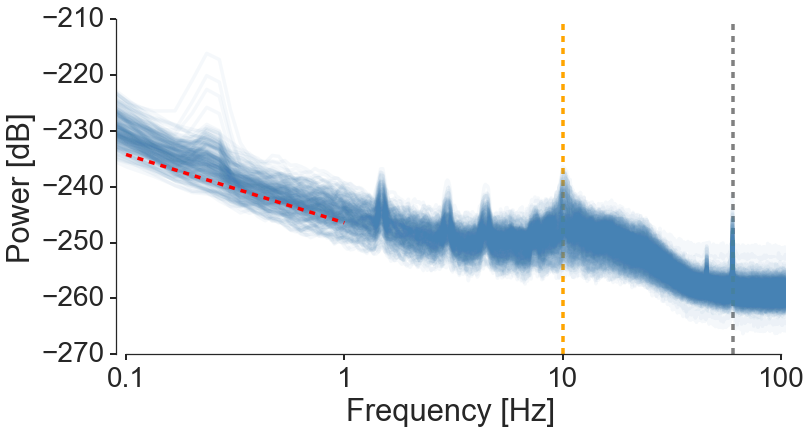

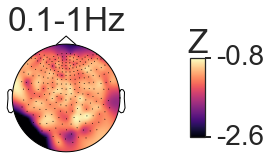

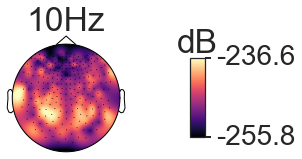

In [192]:
%matplotlib inline
width = 2

sns.set_context("paper", font_scale=3.5,
                rc={"lines.linewidth": 3.5,'axes.linewidth': width,
                    'ytick.major.width': width, 'ytick.minor.width': width,
                    'xtick.major.width': width, 'xtick.minor.width': width})
#
fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
ax = axes
ax.axvline(np.log10(10), color='orange', linestyle='--')
ax.axvline(np.log10(60), color='gray', linestyle='--')
ax.axvline(np.log10(120), color='gray', linestyle='--')

ax.plot(np.log10(freqs), X.mean(0).T * 10, color='steelblue',
         alpha=0.05)

arr_range = np.array([[
    arr['intercepts'].mean(0).mean(0),
    arr['intercepts'].mean(0).mean(0) + arr['coefs'].mean(0).mean(0)
]]).T
ax.plot(np.log10([0.1, 1.0]), arr_range * 10, color='red',
        linestyle='--')
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10([0.09, 105]))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [dB]')

sns.despine(trim=True)

coefs_mne = mne.EvokedArray((arr['coefs']).mean(0, keepdims=True).T,
                            info=epochs.info, tmin=0)
plot_topomap(coefs_mne, [0], unit='Z', title='', time_format='0.1-1Hz');

power_mne = mne.EvokedArray(X[...,
                              np.argmin(np.abs(freqs-10))].mean(0)[..., None] * 10,
                            info=epochs.info, tmin=0)
plot_topomap(power_mne, [0], unit='dB', title='', time_format='10Hz');



In [159]:
df_roi = pd.read_csv('meg_sensor_rois.csv')

In [187]:
rois = df_roi.columns[2:]
print rois

Index([u'frontal_inner_right', u'central', u'temporal_right', u'parietal_left',
       u'frontal', u'frontal_outer_right', u'frontal_inner_left',
       u'parietal_right', u'frontal_outer_left', u'parietal_center',
       u'occiptial', u'temporal_left'],
      dtype='object')


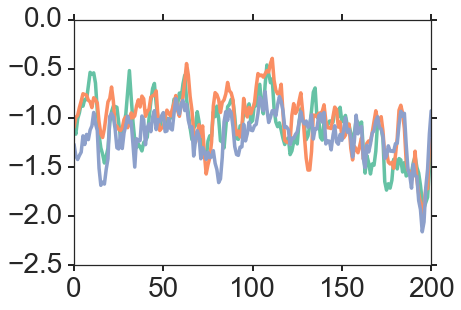

In [188]:
plt.plot(np.array([arr['coefs'][:, df_roi[roi].values].mean(1) for roi in rois if 'parietal' in roi]).T);

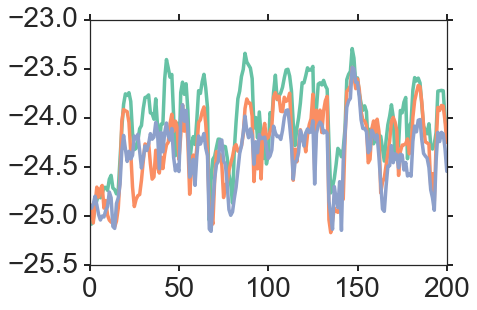

In [190]:
plt.plot(np.array([X[:, df_roi[roi].values].mean(1)[:, 300] for roi in rois if 'parietal' in roi]).T);

In [220]:
roi_power = np.array([X[:, df_roi[roi].values].mean(1)[:, 300] for roi in rois])

roi_coef = np.array([arr['coefs'][:, df_roi[roi].values].mean(1) for roi in rois]).T

In [221]:
corrs = np.corrcoef(roi_power.T[:, :].T,
                    np.log10(roi_coef[:, :].T ** 2))
corrs

array([[  1.00000000e+00,   7.69503421e-01,   7.14725383e-01,
          7.36986290e-01,   7.21435398e-01,   7.96963845e-01,
          5.97986036e-01,   8.05934893e-01,   7.49559258e-01,
          6.72866516e-01,   7.08574407e-01,   7.83925572e-01,
         -5.68559190e-02,  -3.65531921e-03,   6.16050837e-02,
          1.59251618e-02,   1.09435567e-01,   3.05283776e-02,
          4.22964495e-02,  -1.55044838e-01,  -6.93148059e-02,
         -1.65696669e-01,   2.34366151e-02,  -2.93500995e-02],
       [  7.69503421e-01,   1.00000000e+00,   6.47059962e-01,
          6.52627780e-01,   6.87830942e-01,   6.76172171e-01,
          7.47049199e-01,   7.23172748e-01,   7.18092576e-01,
          6.44279644e-01,   6.07010245e-01,   6.69355319e-01,
         -1.34607492e-01,  -9.58651466e-02,  -7.19623565e-04,
         -1.11843727e-01,   3.70614621e-02,  -7.40985883e-02,
         -1.30760373e-01,  -2.38950694e-01,  -1.60021547e-01,
         -1.59123711e-01,   4.85512458e-03,  -1.01908389e-01],
      

(<matplotlib.image.AxesImage at 0x7fb389c22f50>,
 <matplotlib.colorbar.Colorbar at 0x7fb389f72f50>)

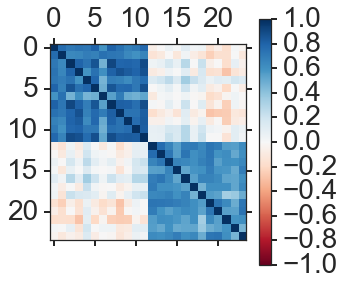

In [222]:
plt.matshow(corrs, cmap='RdBu', vmin=-1, vmax=1), plt.colorbar()

In [258]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score

In [264]:
rf = RandomForestRegressor(n_estimators=300)
for roi_ in roi_coef.T:
#     rf.fit(roi_power.T, roi_)
#     print r2_score(rf.predict(roi_power.T), roi_)
#     print(1 - rf.oob_score_)
    print(cross_val_score(estimator=rf, X=X[..., 300], y=roi_, scoring='r2', cv=5).mean())

-0.974016085229
-0.345919551101
-1.2276636151
-2.2887944686
-0.838991228323
-0.406218648005
-1.14895932298
-1.14437707631
-0.3634330233
-0.567004208056
-0.500427803679
-0.984897096704


(12, 201)